<a href="https://colab.research.google.com/github/Nkashyap-anand/human-posture-estimation/blob/main/resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow import keras
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split

In [8]:
# Create ImageDataGenerator to handle loading and preprocessing images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the images from your local storage
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/posture/training',
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/posture/validation',
    target_size=(512, 512),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2304 images belonging to 4 classes.
Found 192 images belonging to 4 classes.


In [9]:
def resnet18_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
      """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
      conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(1e-4))

      x = inputs
      if conv_first:
          x = conv(x)
          if batch_normalization:
              x = BatchNormalization()(x)
          if activation is not None:
              x = Activation(activation)(x)
      else:
          if batch_normalization:
              x = BatchNormalization()(x)
          if activation is not None:
              x = Activation(activation)(x)
          x = conv(x)
      return x

def resnet18(input_shape, num_classes=10):
    """ResNet18 model builder
    """
    inputs = Input(shape=input_shape)
    x = ZeroPadding2D(padding=(3, 3))(inputs)
    # stage 1
    x = Conv2D(64, kernel_size=7, strides=2, padding='valid', kernel_initializer='he_normal', name='conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # stage 2
    x = resnet18_layer(inputs=x, num_filters=64)
    x = resnet18_layer(inputs=x, num_filters=64)

    # stage 3
    x = resnet18_layer(inputs=x, num_filters=128, strides=2)
    x = resnet18_layer(inputs=x, num_filters=128)

    # stage 4
    x = resnet18_layer(inputs=x, num_filters=256, strides=2)
    x = resnet18_layer(inputs=x, num_filters=256)

    # stage 5
    x = resnet18_layer(inputs=x, num_filters=512, strides=2)
    x = resnet18_layer(inputs=x, num_filters=512)

    # output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the ResNet model
model = resnet18(input_shape=(512, 512, 1), num_classes=4)


# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model using the generator
history = model.fit_generator(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=train_generator.samples // 32,
                              validation_steps=validation_generator.samples // 32,
                              epochs=10)



<ipython-input-9-e88135f181ab>:88: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
72/72 [==============================] - 1567s 21s/step - loss: 1.0718 - accuracy: 0.7483 - val_loss: 4.0654 - val_accuracy: 0.3906
Epoch 2/10
72/72 [==============================] - 23s 320ms/step - loss: 0.8752 - accuracy: 0.8194 - val_loss: 2.2128 - val_accuracy: 0.5521
Epoch 3/10
72/72 [==============================] - 23s 318ms/step - loss: 0.7646 - accuracy: 0.8498 - val_loss: 1.4560 - val_accuracy: 0.5938
Epoch 4/10
72/72 [==============================] - 22s 307ms/step - loss: 0.6960 - accuracy: 0.8550 - val_loss: 2.4361 - val_accuracy: 0.4375
Epoch 5/10
72/72 [==============================] - 23s 321ms/step - loss: 0.6481 - accuracy: 0.8707 - val_loss: 5.6699 - val_accuracy: 0.4531
Epoch 6/10
72/72 [==============================] - 23s 315ms/step - loss: 0.5867 - accuracy: 0.8854 - val_loss: 0.7954 - val_accuracy: 0.8177
Epoch 7/10
72/72 [==============================] - 24s 324ms/step - loss: 0.5609 - accuracy: 0.8828 - val_loss: 1.4583 - val_accuracy: 0.6510

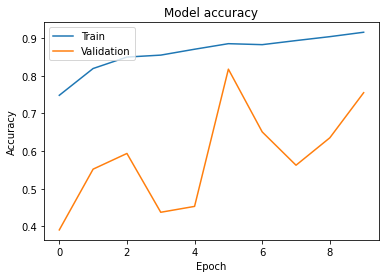

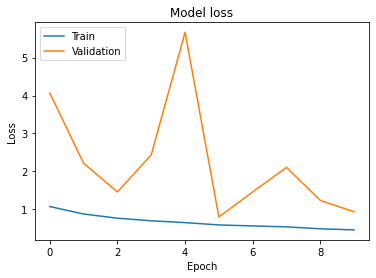

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
